In [1]:
# Run this notebook with  jupyter notebook --NotebookApp.max_buffer_size=12884901888
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("EnsDb.Hsapiens.v86",force=TRUE)
#BiocManager::install(version = "3.14",ask=FALSE)
#BiocManager::install("GenomeInfoDb",force=TRUE)


In [16]:
library(ggplot2)
loadfonts(device = "win")
windowsFonts()

ERROR: Error in loadfonts(device = "win"): could not find function "loadfonts"


In [3]:
library(dplyr)
library(ggplot2)
library(EnsDb.Hsapiens.v86)
library(Seurat)
library(Signac)
library(repr)
library(ape)
#sessionInfo()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Load

ERROR: Error in library(ape): there is no package called 'ape'


In [4]:
data_root="~/OneDrive - Sanford Burnham Prebys Medical Discovery Institute/projects/scRNA+ATAC"
sample_name <- "rcmb56-ht"
#sample_name <- "rcmb56-pdx"

if (sample_name == 'rcmb56-ht'){
    file = file.path(data_root,"RCMB56-ht/cellranger-2.0.0/outs/filtered_feature_bc_matrix")
    frag.file <- file.path(data_root,"RCMB56-ht/cellranger-2.0.0/outs/atac_fragments.tsv.gz")
} else if (sample_name == 'rcmb56-pdx'){
    file <- file.path(data_root,"RCMB56-pdx/cellranger-2.0.0/outs/filtered_feature_bc_matrix")
    frag.file <- file.path(data_root,"RCMB56-pdx/cellranger-2.0.0/outs/atac_fragments.tsv.gz")
}
tx_data <- Read10X(data.dir = file)

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [5]:
# extract RNA and ATAC data
rna_counts <- tx_data$`Gene Expression`
atac_counts <- tx_data$Peaks
rm(tx_data)

# Create Seurat object
seuratobj <- CreateSeuratObject(counts = rna_counts)
seuratobj[["percent.mt"]] <- PercentageFeatureSet(seuratobj, pattern = "^MT-")

# Now add in the ATAC-seq data
# we'll only use peaks in standard chromosomes
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(":", "-"))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"
chrom_assay <- CreateChromatinAssay(
   counts = atac_counts,
   sep = c(":", "-"),
   genome = 'hg38',
   fragments = frag.file,
   min.cells = 10,
   annotation = annotations
 )
seuratobj[["ATAC"]] <- chrom_assay

seuratobj

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

An object of class Seurat 
119872 features across 4473 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ATAC

In [7]:
# QC checks
gg = VlnPlot(seuratobj, features = c("nCount_ATAC", "nCount_RNA","percent.mt"), ncol = 3,
  log = TRUE, pt.size = 0) + NoLegend()
qc_file = paste0(sample_name,"_qc.svg")
dir.create("out")
ggsave(file.path("out",qc_file),gg)

Warning message in dir.create("out"):
"'out' already exists"
Saving 7 x 7 in image


In [8]:
# QC thresholds based on qc plot
if (sample_name == 'rcmb56-ht'){
    seuratobj <- subset(x = seuratobj, subset = 
                        nCount_ATAC < 7e4 &
                        nCount_ATAC > 1e3 &
                        nCount_RNA < 25000 &
                        nCount_RNA > 500 &
                        percent.mt < 10
        )
} else if (sample_name == 'rcmb56-pdx'){
    seuratobj <- subset(x = seuratobj, subset =
                        nCount_ATAC < 7e4 &
                        nCount_ATAC > 1e3 &
                        nCount_RNA < 25000 &
                        nCount_RNA > 1e3 &
                        percent.mt < 10
        )
    # get only human cells.
    xenocell_human_barcodes_file <- "../2021-11-01_xenocell/cellular_barcodes.txt"
    human_barcodes <- read.delim(xenocell_human_barcodes_file, header=FALSE, sep='\n')
    human_barcodes <- human_barcodes$V1
    human_barcodes <- paste0(human_barcodes,"-1")
    seuratobj <- subset(x=seuratobj,cells=human_barcodes)
    rm(human_barcodes)
}
#ht - 4473 -> 2986 cells
#pdx - 12869 -> 10400 cells
seuratobj

An object of class Seurat 
119872 features across 2986 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ATAC

PC_ 1 
Positive:  RNF220, UNC5C, QKI, PTPRK, NCKAP5, NCAM2, NPAS3, ZEB2, PPP2R2B, CTNNA3 
	   GAB1, FRMD4A, DOCK10, FRMD4B, ADARB2, DPYD, ERBIN, GRID1, PREX1, DCC 
	   CASC15, PCDH9, PARD3, STARD13, DOCK1, SLC24A2, PIP4K2A, SEMA6D, SPOCK3, DOCK5 
Negative:  KCNIP4, RBFOX1, ZNF385D, CDH18, SNHG14, KCND2, GRIK2, FGF14, NRXN1, RIT2 
	   CNTNAP2, ZFPM2, SYNPR, RALYL, LHFPL6, SYT1, ZNF385B, SLC35F4, AC013287.1, CNTN4 
	   NEGR1, PDE1A, OPCML, PDE10A, STARD4-AS1, TRPM3, NRG1, LINC00632, AC105411.1, FAM160A1 
PC_ 2 
Positive:  CASC15, DCDC1, BOC, DCC, ZEB1, TMEM108, GLI2, KALRN, SEMA6D, ADAMTS6 
	   CCSER1, L3MBTL4, AC004852.2, PDLIM3, SEZ6L, HS2ST1, NTN1, ROR1, COL25A1, PLCH1 
	   PARD3, NFIB, MYO16, KCNT2, AC008780.1, PRLR, DACH1, BCAR3, NKAIN3, DSCAM 
Negative:  PCDH9, PPP2R2B, MBP, IL1RAPL1, CTNNA3, PLP1, MOBP, TF, DOCK5, C10orf90 
	   PIP4K2A, DOCK10, PEX5L, MOG, QKI, SLC24A2, ARAP2, PLEKHH1, SPOCK3, ENPP2 
	   SYNJ2, SLC44A1, BCAS1, EDIL3, NPAS3, CLMN, SLC7A14-AS1, SHTN1, CLDN11, FRMD4B

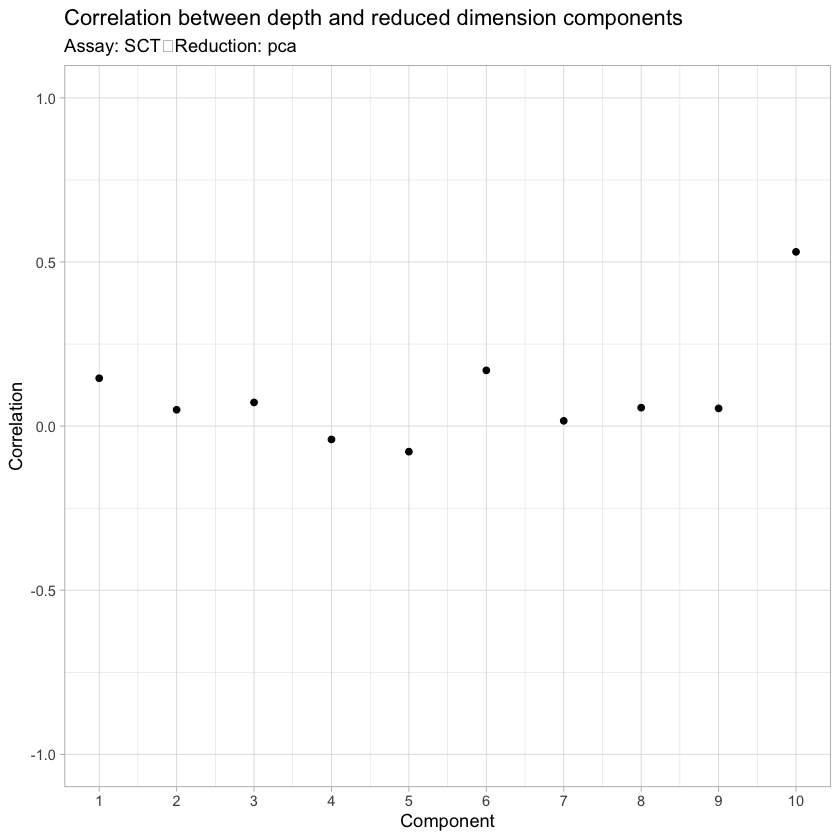

In [9]:
# Dimensionality reduction on RNA data
DefaultAssay(seuratobj) <- "RNA"
seuratobj <- SCTransform(seuratobj, return.only.var.genes = TRUE, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

#seuratobj <- SCTransform(seuratobj, return.only.var.genes = FALSE, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

# check PCs against sequencing depth
options(repr.plot.width = 7, repr.plot.height = 7)
DepthCor(seuratobj,reduction='pca')

In [10]:
seuratobj

An object of class Seurat 
140455 features across 2986 samples within 3 assays 
Active assay: SCT (20583 features, 3000 variable features)
 2 other assays present: RNA, ATAC
 2 dimensional reductions calculated: pca, umap.rna

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

19:29:39 UMAP embedding parameters a = 0.9922 b = 1.112

19:29:39 Read 2986 rows and found 49 numeric columns

19:29:39 Using Annoy for neighbor search, n_neighbors = 30

19:29:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:29:39 Writing NN index file to temp file /var/folders/mz/x6bkt9t91j598wz6hnwc7b2m0000gp/T//RtmpSuxa1W/file101255cfa4eba

19:29:39 Searching Annoy index using 1 thread, search_k = 3000

19:29:40 Annoy recall = 100%

19:29:40 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

19:29:41 Initializing from normalized Laplacian + noise (using irlba)

19:29:41 Commencing optimization for 500 epochs, with 132964 positive edges

19:29:46 Optimiz

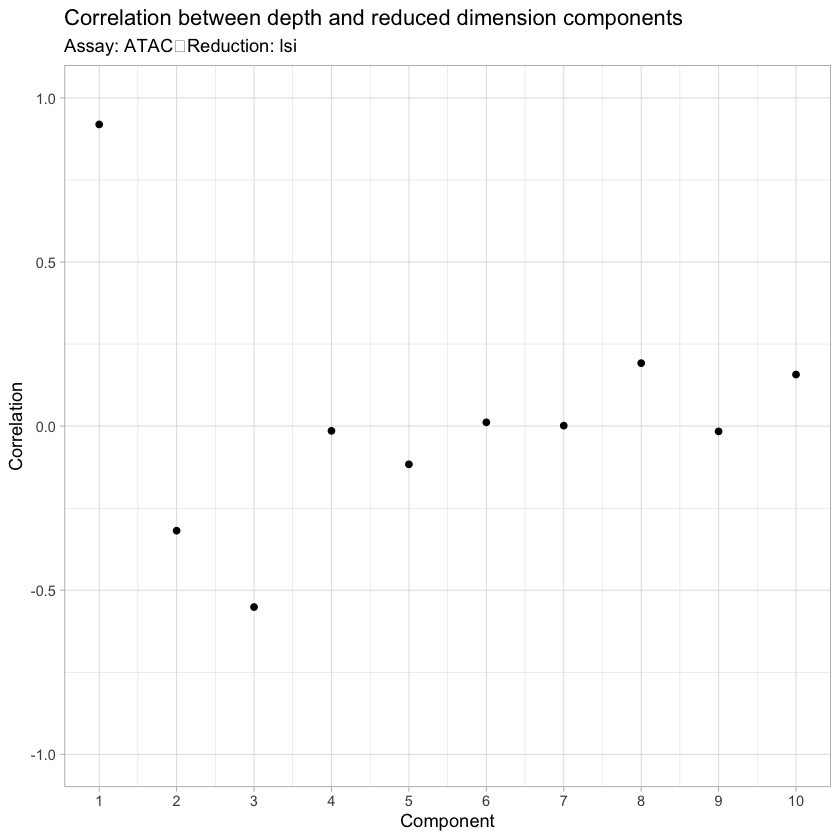

In [11]:
# Dimensionality reduction on ATAC data 
DefaultAssay(seuratobj) <- "ATAC"
seuratobj <- RunTFIDF(seuratobj)
seuratobj <- FindTopFeatures(seuratobj, min.cutoff = 'q0')
seuratobj <- RunSVD(seuratobj)
seuratobj <- RunUMAP(seuratobj, reduction = 'lsi', dims = 2:50, reduction.name = "umap.atac", reduction.key = "atacUMAP_")
# check PCs against sequencing depth
options(repr.plot.width = 7, repr.plot.height = 7)
DepthCor(seuratobj,reduction='lsi')

In [12]:
# WNN multimodal clustering
seuratobj <- FindMultiModalNeighbors(seuratobj, reduction.list = list("pca", "lsi"), dims.list = list(1:50, 2:50))
seuratobj <- RunUMAP(seuratobj, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

19:29:51 UMAP embedding parameters a = 0.9922 b = 1.112

19:29:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

19:29:53 Initializing from normalized Laplacian + noise (using irlba)

19:29:53 Commencing optimization for 500 epochs, with 93960 positive edges

19:29:57 Optimization finished



In [13]:
seuratobj <- FindClusters(seuratobj, graph.name = "wsnn", resolution=.1, algorithm = 3, verbose = FALSE)

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label

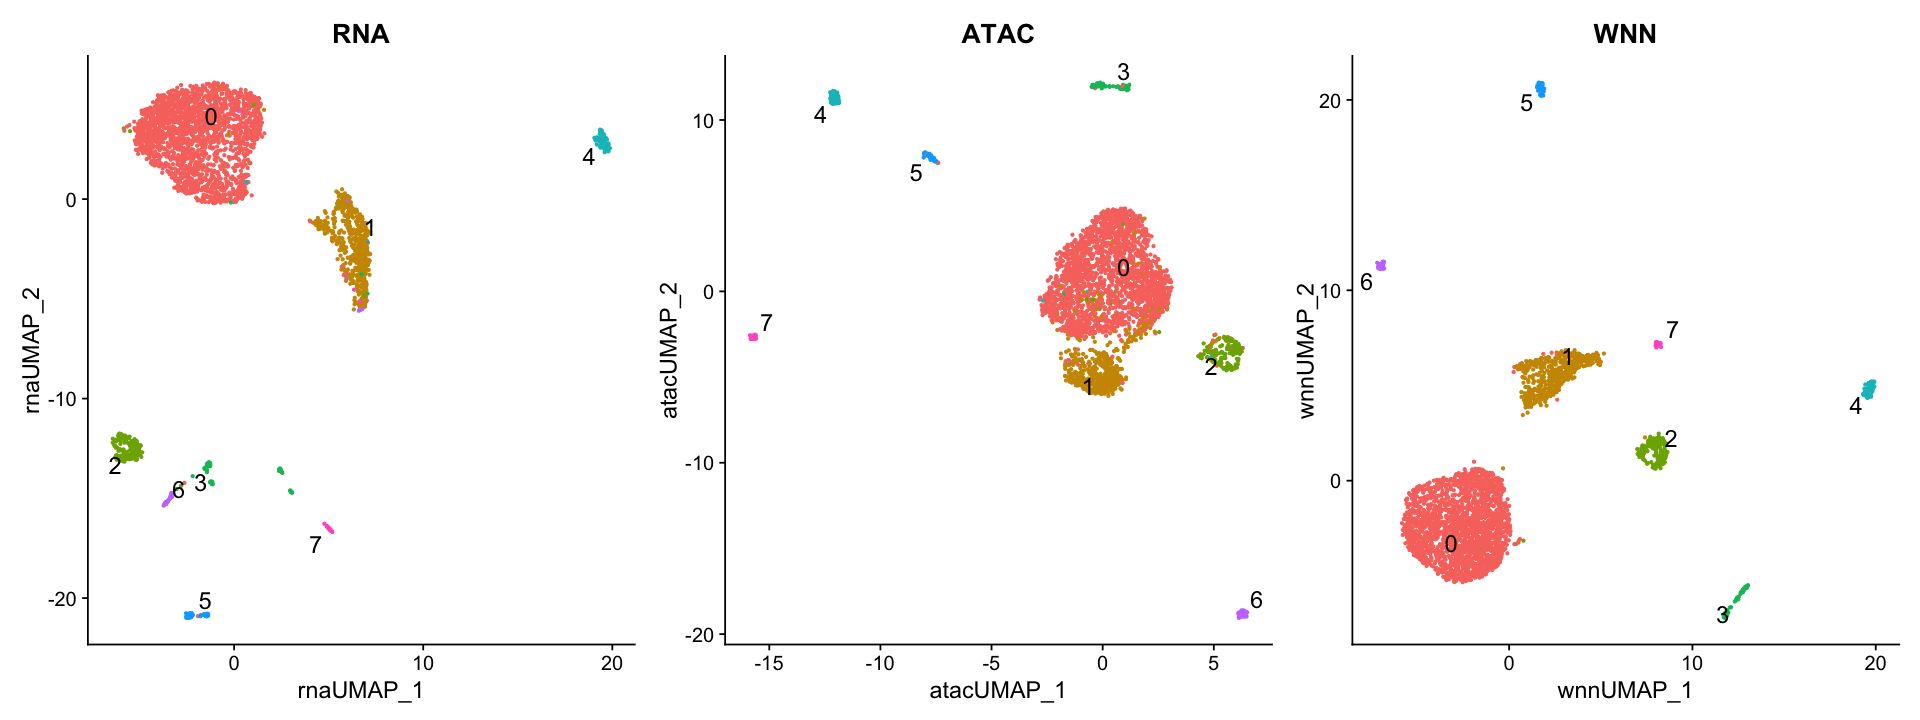

In [14]:
# Plot UMAPs
options(repr.plot.width = 16, repr.plot.height = 6)
p1 <- DimPlot(seuratobj, reduction = "umap.rna", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(seuratobj, reduction = "umap.atac", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(seuratobj, reduction = "wnn.umap", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("WNN")
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5),
                                 text = element_text(family = "Arial"))
img_file = paste0(sample_name,"_RNA+ATAC+WNN_UMAP.svg")
ggsave(file.path("out",img_file),width=16, height=6)

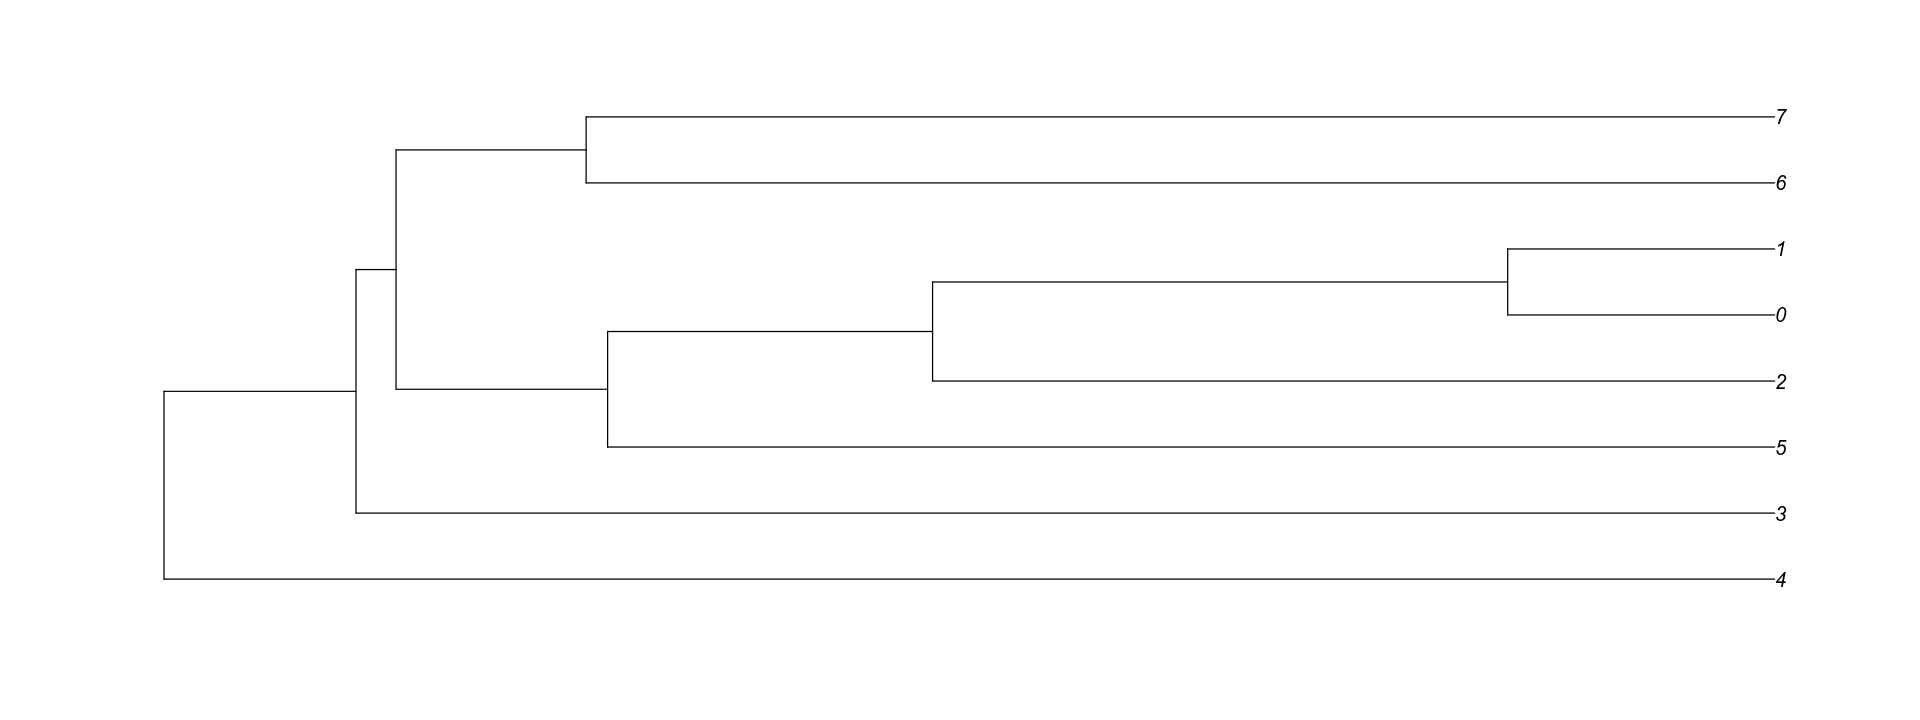

In [49]:
# This doesn't really work -- looks like all clusters are equally far away from each other according to the wsnn graph.
seuratobj <- BuildClusterTree(seuratobj,graph="wsnn")
# From RNA-seq PCs 1-10, non-tumor cluster together, then ecDNA+, then normal cell types.
seuratobj <- BuildClusterTree(seuratobj,reduction="pca",dims=1:10)
# ape::plot.phylo(Tool(object=seuratobj, slot='BuildClusterTree'),use.edge.length=FALSE)
# lol high-dimensional space what the fuck
ape::plot.phylo(Tool(object=seuratobj, slot='BuildClusterTree'))

## Save various tables

In [15]:
DefaultAssay(seuratobj) <- "SCT"

# Save relevant objects and data tables
saveRDS(seuratobj,file.path("out",paste(sample_name,"_seuratobj.rds",sep="")))

In [ ]:
# Read with:
#seuratobj <- readRDS(paste0(sample_name,"_seuratobj.rds"))
#seuratobj

In [ ]:
######################################################################

# 12/21/2021
Save metadata table with Sunita's updates namely reclustering after filtering xenocell and doublets.

In [ ]:
sample_name <- 'rcmb56-ht'

if (sample_name == 'rcmb56-ht'){
    rds <- 'rcmb56-ht_seuratobjdfclean.rds'
} else if(sample_name == 'rcmb56-pdx'){
    rds <- 'rcmb56-pdx_xenocelldfcleanseuratobj.rds'
}
seuratobj <- readRDS(rds)
write.table(seuratobj[[]],paste(sample_name,'_seurat_metadata_clean.tsv',sep=""),sep='\t')

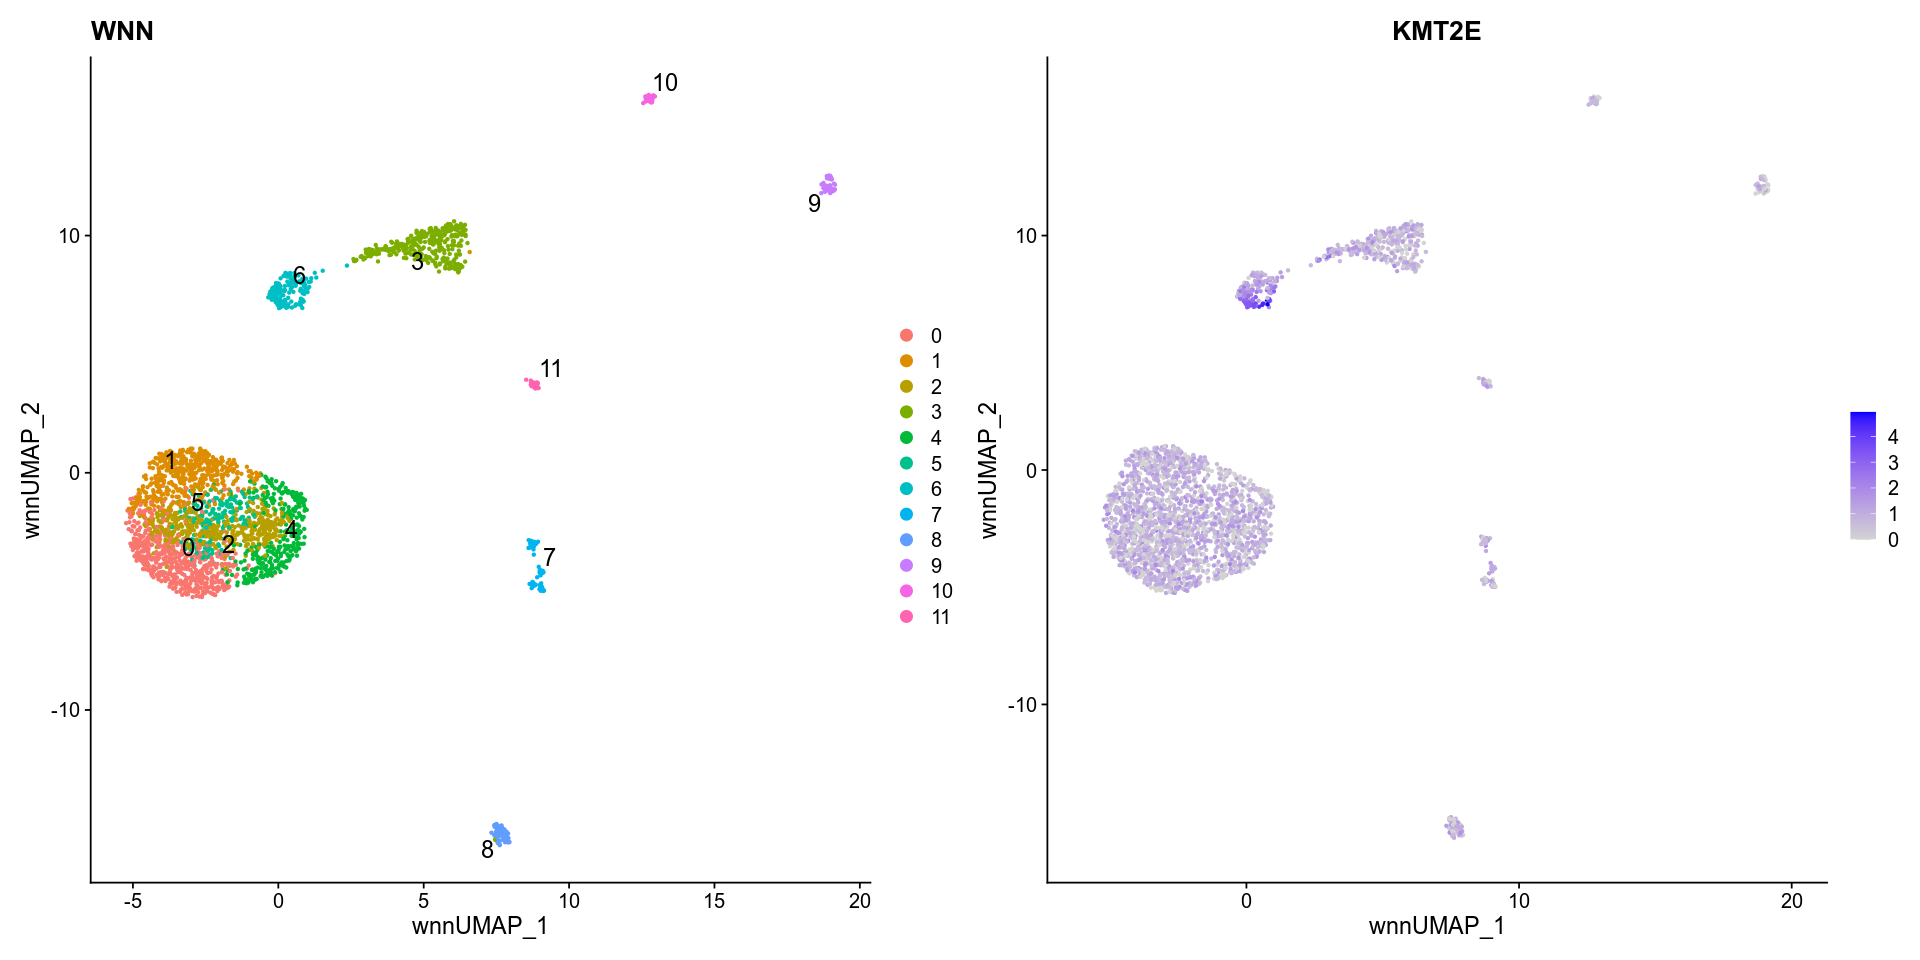

In [19]:
DefaultAssay(seuratobj) <- 'SCT'
options(repr.plot.width=16, repr.plot.height=8)
p1 <- DimPlot(seuratobj, reduction = "wnn.umap", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("WNN")
p2 <- FeaturePlot(seuratobj, features="KMT2E",reduction="wnn.umap")
p1 + p2

In [16]:
seuratobj

An object of class Seurat 
140455 features across 2762 samples within 3 assays 
Active assay: SCT (20583 features, 3000 variable features)
 2 other assays present: RNA, ATAC
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, wnn.umap

# Dead code

In [ ]:
# Get scaled gene expression
gene = 'DNTTIP2'
#gene = 'ARHGAP29'
#gene = 'KMT2E'
DefaultAssay(seuratobj) <- "SCT"
m <- GetAssayData(seuratobj, slot="data")
library(data.table)
m <- data.table(barcode = names(m[gene, ]),DNTTIP2 = m[gene, ])
write.table(m,paste0(sample_name,'_dnttip2.data.sct.tsv'),sep='\t')

In [ ]:
# save metadata, including cluster identities
write.table(seuratobj[[]],paste(sample_name,'_seurat_metadata.tsv',sep=""),sep='\t')

# save cell embeddings
DefaultAssay(seuratobj) <- "SCT"
write.table(Embeddings(seuratobj, reduction='pca'),paste(sample_name,'_seurat_rna_cell_embeddings.tsv',sep=""),sep='\t')
DefaultAssay(seuratobj) <- "ATAC"
write.table(Embeddings(seuratobj, reduction='lsi'),paste(sample_name,'_seurat_atac_cell_embeddings.tsv',sep=""),sep='\t')
write.table(Embeddings(seuratobj, reduction='wnn.umap'),paste(sample_name,'_seurat_wnn_embeddings',sep=""),sep='\t')

In [ ]:
# WNN multimodal clustering
detailed_clusters <- FindClusters(seuratobj, resolution=2, graph.name = "wsnn", algorithm = 3, verbose = FALSE)

# Plot UMAPs
options(repr.plot.width = 16, repr.plot.height = 6)
p1 <- DimPlot(detailed_clusters, reduction = "umap.rna", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(detailed_clusters, reduction = "umap.atac", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(detailed_clusters, reduction = "wnn.umap", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("WNN")
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))

In [ ]:
detailed_clusters <- BuildClusterTree(detailed_clusters,graph="wsnn")
ape::plot.phylo(Tool(object=detailed_clusters, slot='BuildClusterTree'),use.edge.length=FALSE)